In [2]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 1024)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")
prefix = 'pickle'

In [4]:
from io import BytesIO

def fix(map_loc):
    return lambda b: torch.load(BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

In [5]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [6]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [7]:
import os
import pickle
from copy import copy, deepcopy
import zipfile

pre_keys = ['pre_output_proba_topn',
 'pre_output_proba_topk',
 'pre_output_true_entropies',
 'pre_output_layers_kl']

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('zip'):
        print(file)
        archive = zipfile.ZipFile(os.path.join(prefix, file), 'r')
        for pid, single_file in enumerate(tqdm(archive.filelist)):
            
            if single_file.filename.startswith('_') or single_file.filename.startswith('.'): continue
                
            item = mapped_loads(archive.read(single_file.filename))
            
            for i, _ in enumerate(item["post_output_sequences"]):
                
                item_ = copy(item)
                item_["post_output_sequences"] = item["post_output_sequences"][i]
                
                item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 

                item_["post_output_layers_kl"] = item["post_output_layers_kl"][i]
                item_["transition_scores_s"] = item["transition_scores_s"][i]
                item_["transition_scores_l"] = item["transition_scores_l"][i]

                item_["run"] = run + i
                
                outlist.append(item_)
                
                # whatever is generated for pre_ is propagated to the first run only
                if i == 0:
                    for k in pre_keys: item.pop(k, None)
      
        run = run + i + 1 # next zip file

len(outlist)

llama3.1-8b.zip


  0%|                                                  | 0/1502 [00:00<?, ?it/s]/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_11671/3807410893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

15020

In [8]:
model_name = item['args']['model_name'] # get model from last processed item
model_name_short = model_name.split('/')[-1].lower()
print(model_name)

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

meta-llama/Llama-3.1-8B-Instruct


### check output against ground truth

In [9]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

pdbg = None

for idx, p in enumerate(outlist):
    
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    c+=1
    pdbg = p
    
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    a = " ".join(a.split(" "))
    if len(a) < 1: 
        print("SOMETHING WENT HORRIBLY WRONG, GIVING UP")
        break

    b = p['output'].lower().strip()
    b = " ".join(b.split(" "))
    
    # correct
    correct = False
    hallucinated = False
    if ((a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b))) and (('desc' in a) and ('type' in a)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        
    # loose correctness
    _, three_ = b.split('[type]')
    one_, two_ = _.split('[desc]')
    one_ = one_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    two_ = two_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    three_ = three_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    
    loosely_correct = False
    matched_string = None
    try:                 
        # anywhere, including after :
        regex = re.compile(
            r'(?:(?<=^)|(?<=[:\n<#]))'               # start of string or after : or \n
            r'.{0,4}?'                             # up to 4 junk chars (non-greedy)
            r'([^\[\]><]{4,128})'                  # first core field
            r'\[.{0,8}\]'                          # bracketed junk
            r'([^\[\]><]{4,128})'                  # second core field
            r'\[.{0,8}\]'                          # bracketed junk
            r'([^\[\]><#\n]{4,128})'             # third core field (but STOP at #, or \n)
        )
        matched = False
        for match in regex.finditer(a):  # loop over all matches
            matched = True
            if (match.group(1).strip() == one_ and 
                match.group(2).strip() == two_ and 
                match.group(3).strip() == three_):
                loosely_correct = True
                break
        # rightmost match if not correct
        if matched:
            matched_string = match.group(1).strip() + " [desc] " + match.group(2).strip() + " [type] " + match.group(3).strip()

            
    except Exception as e:
        pass# if it fails, default

    truth.append((p['run'], p['pid'], correct, hallucinated, loosely_correct))
    outseq.append((p['run'], p['pid'], a, post_output_sequences, b, matched_string))


CPU times: user 59.4 s, sys: 3.81 s, total: 1min 3s
Wall time: 1min 12s


In [10]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(3768, 3832)

In [11]:
# true, hallucinated, counted
t, h, c

(4676, 10251, 15020)

In [12]:
# correct answers rate, hallucinated answers rate
t/c, h/c

(0.31131824234354194, 0.6824900133155792)

In [13]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated', 'loosely_correct'])

In [14]:
corec = truth.groupby('pid').correct.mean()

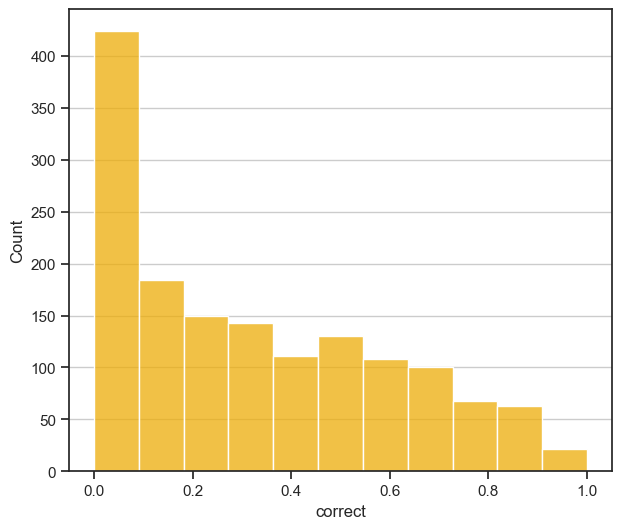

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corec, bins=corec.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

In [34]:
# probability mass for "convinced" prediction
(np.isclose(corec, 0.) | np.isclose(corec, 1.)).sum() / corec.shape[0]

0.296271637816245

In [35]:
# how many "changed at least once"
((corec>0.) & (corec<1.)).sum() / corec.shape[0]

0.703728362183755

In [36]:
# again but without hallucinated

truth_ = truth[(~truth.hallucinated)].copy()
truth_['true_err'] = truth_.correct

corec_ = truth_.groupby('pid').true_err.mean()

((corec_>0.) & (corec_<1.)).sum() / corec_.shape[0]

0.030973451327433628

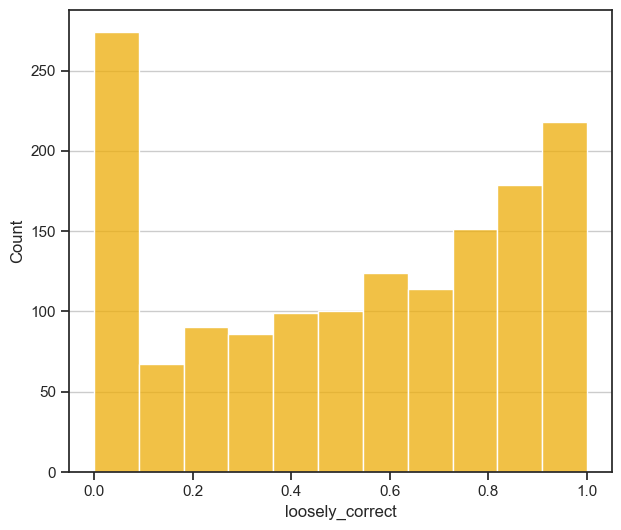

In [37]:
# loosely correct

import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

corek = truth.groupby('pid').loosely_correct.mean()

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corek, bins=corek.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


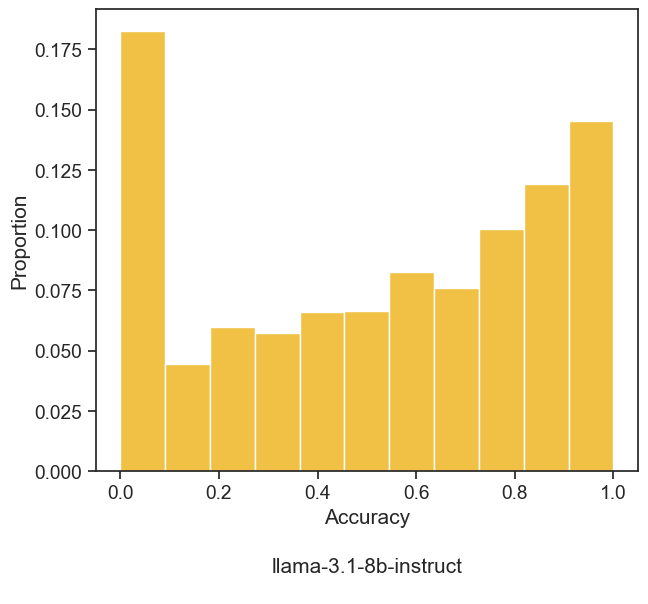

In [193]:
# loosely correct

import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_context("notebook", font_scale=1.25)

# sns.set_theme(style="ticks")

corek = truth.groupby('pid').loosely_correct.mean()

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corek, bins=corek.nunique(), color=Prism_10.mpl_colors[5], stat="probability")

# ax.yaxis.grid(True)

plt.legend(
    title=model_name_short,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    frameon=False,
    ncol=3,
    columnspacing=0.8,
    handletextpad=0.4
)

plt.xlabel("Accuracy")
plt.ylabel("Proportion")

plt.savefig("loosely_correct_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

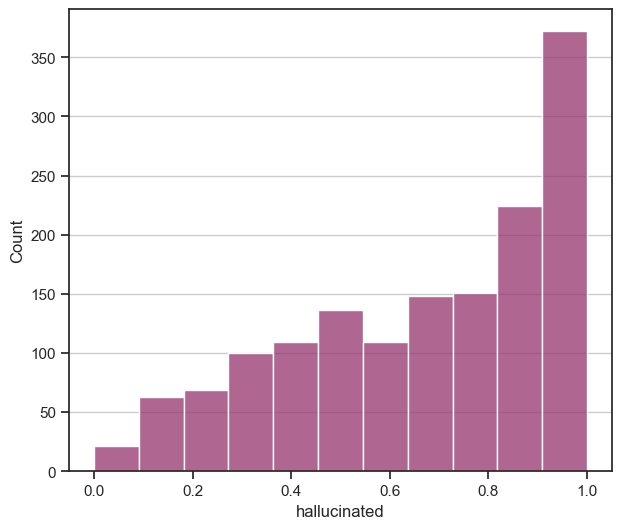

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(truth.groupby('pid').hallucinated.mean(), bins=corec.nunique(), color=Prism_10.mpl_colors[8])

ax.yaxis.grid(True)

plt.show()

In [50]:
# how many hallucinated
(truth.groupby('pid').hallucinated.mean()>0.).sum() / truth.pid.nunique()

0.9860186418109188

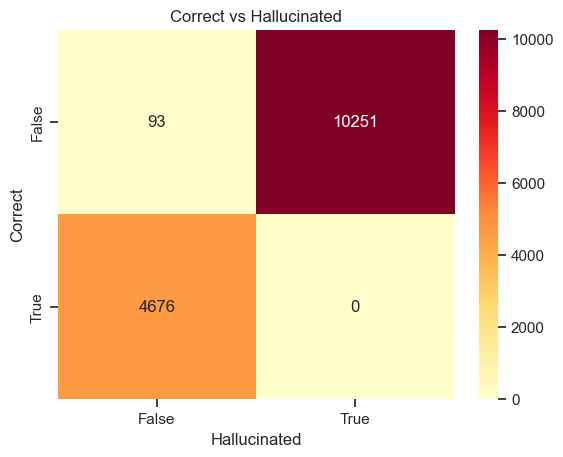

In [51]:
contingency = pd.crosstab(truth.correct, truth.hallucinated)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Hallucinated")
plt.ylabel("Correct")
plt.show()

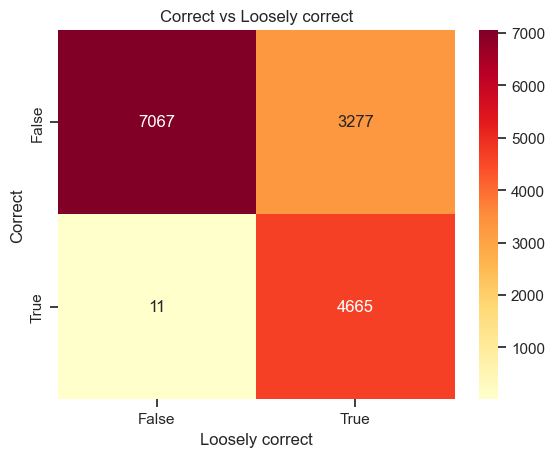

In [52]:
contingency = pd.crosstab(truth.correct, truth.loosely_correct)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Loosely correct")
plt.xlabel("Loosely correct")
plt.ylabel("Correct")
plt.show()

In [53]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer', 'regex_match'])
answers.answer = answers.answer.str[:-1]

In [54]:
# min and max number of unique answers
answers.groupby('pid').answer.nunique().min(), answers.groupby('pid').answer.nunique().max()

(6, 10)

In [55]:
answers[:20]

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,129,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with a content of 'netbal","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
1,1,129,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selected this candidate based on the information provided in the table cells. thi,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
2,2,129,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct referent entity in the list of candidates.\n\n### step 2: e","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
3,3,129,"ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever, there are a few potential issues with this answer. firstly, 'ball spor","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,## response:\nnetball [desc] ball sport [type] type of sport
4,4,129,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n\n### step 2: examining the referent entity candidate","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
5,5,129,netball [desc] ball sport [type] type of sport> is not the answer as the question is about 'netball' sportsperson. the answer to this question must be 'amanda newton'. the correct referent entity for the entity mention ’netball’ is therefore netballer [des,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball spor

In [56]:
# wrong answers

import numpy as np
def fun (a,b):
    return a.startswith(b) or b.startswith(a)

foon = np.vectorize(fun)
aoh = pd.Series(foon(answers.answer, answers.right_answer), index=answers.index)

answers[~aoh]

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,129,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with a content of 'netbal","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
1,1,129,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selected this candidate based on the information provided in the table cells. thi,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
2,2,129,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct referent entity in the list of candidates.\n\n### step 2: e","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
3,3,129,"ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever, there are a few potential issues with this answer. firstly, 'ball spor","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,## response:\nnetball [desc] ball sport [type] type of sport
4,4,129,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n\n### step 2: examining the referent entity candidate","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
...,...,...,...,...,...,...
15015,5,599,"<philippe sutherland [desc] french basketball player [type] sport cyclist]> doesn't match the entity mention 'sutherland'. there is a <sutherland [desc] suburb of sydney, australia [type] suburb> that should be chosen instead. \n\nthe final answer is: <sutherland [des","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...","<sutherland [desc] former 

In [57]:
# correct but not loosely correct?
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(~gg.loosely_correct) & (gg.correct)]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
4311,1,402,True,False,False,"[desc] kenyan paleoanthropologist, conservationist, and politician [type] conservationist","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...","<richard leakey [desc] kenyan paleoanthropologist, conservationist, and politician [type] conservationist>",None
8000,0,650,True,False,False,<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family>.</5> [desc] natural number [type] fibonacci prime>.</mu [desc] genetic element in the species drosophila melanogaster [type] gene>.</mu [des,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family>,/mu [desc] genetic element in the species drosophila melanogaster [type] gene
8001,1,650,True,False,False,<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family> # correct answer # done # do not change # do not add # only the correct answer is required. # you are done when the correct answer has been provided. # do no,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family>,None
8002,2,650,True,False,False,"<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family>>. ###\n\nplease note that the actual response may need to be modified to conform to the required format, as the given format requires only the response, without the additional text. the provided response includes a...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family>,None
8003,3,650,True,False,False,"<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family> # correct answer # \n\n### additional answer:\nthis question is a classic example of the entity linking task, and it requires identifying the correct referent entity for the given entity mention ""mu"" based on the p...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family>,None
8005,5,650,True,False,False,"<mu [desc] series of japanese solid-fueled carrier rockets [type] rocket family> \n\nnote: you are not required to answer the question directly in the input prompt, but you need to select an entity from the given options, as it is shown in the provided template. each option contains information o","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 346

In [58]:
pd.set_option('max_colwidth', 300)

In [59]:
gg[gg.regex_match.isnull()][:20]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
45,5,125,False,True,False,the selected candidate must be reported verbatim from the list provided as input. each candidate in the list is enclosed between < and > and reports [desc] and [type] information. the selected candidate must report the type'sheading'. the correct referent entity for the entity mention 'rushen' i,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<rushen [desc] parish in the sheading of the same name in the isle of man [type] parish of the isle of man>,None
132,2,934,False,True,False,"[desc] country in western europe [type] oecd country]. \n\nnote that the input data is given in a structured format as a table, but the question is asking for a match of a specific cell in the table (col2) with a specific type of information. the response is then a simple choic","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<france [desc] country in western europe [type] oecd country>,None
152,2,1331,False,True,False,"ana\nthe best answer is guyana. the selected entity mention in the table cell is ""lorie ann adams (guy)"". the column name for ""lorie ann adams (guy)"" is col1. the referent entity candidates are all entities that have a description and a type.","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<guyana [desc] country in south america [type] sovereign state>,None
157,7,1331,False,True,False,"guyana\n\nthe final answer is: guyana. \n\nnote: the provided input, with the question in the last section, can also be described as a question that inquires about the correct referent entity for an entity mention. this means it also qualifies as a question in the context of the original tas","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<guyana [desc] country in south america [type] sovereign state>,None
180,0,1543,False,True,False,"do not remove this line) ###\n\njannis ramírez (nca) was not in the list of candidates. however, jannis kounellis is, so we will choose the one that looks most similar, which is: <jannis kounellis [desc] exhibition [type","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<nicaragua [desc] sovereign state in central america [type] sovereign state>,None
181,1,1543,False,True,False,"jannis ramírez ( nca ) is found in the table cell row13. looking at the description of jannis ramírez ( nca ), it refers to 'maría lourdes ruiz ( nca )'s competitor in the shot put event. from row 14, it can b","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502

In [60]:
# only loosely correct
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(gg.loosely_correct) & (~gg.correct)].drop_duplicates(subset='pid')

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match
0,0,129,False,True,True,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with a content of 'netbal","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
34,4,344,False,True,True,minnesota [desc] state of the united states of america [type] u.s. state]. \n### the end. ### this response was generated using a neural network-based model. it selects the entity mention 'minnesota' and finds its corresponding column name 'col3' as'state'. among the lis,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<minnesota [desc] state of the united states of america [type] u.s. state>,minnesota [desc] state of the united states of america [type] u.s. state
50,0,1364,False,True,True,"toyota [desc] japanese multinational automotive manufacturer [type] commercial organization]> ### note: please do not include the closing parenthesis in the response. just the description verbatim from the list provided as input. there is no closing parenthesis for a description. however, the d...","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<toyota [desc] japanese multinational automotive manufacturer [type] commercial organization>,toyota [desc] japanese multinational automotive manufacturer [type] commercial organization
73,3,47,False,True,True,elmer fudd [desc] warner bros. cartoon character [type] looney tunes character>>. ### step 1: identify the context of the task.\nthe task involves linking an entity mention in a table to a referent entity from a list of candidates. the context is to identify the correc,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<elmer fudd [desc] warner bros. cartoon character [type] looney tunes character>,elmer fudd [desc] warner bros. cartoon character [type] looney tunes character
110,0,901,False,True,True,ducati corse [desc] ducati motorcyle racing team [type] motorcycle racing team]> ###\n\nthe final answer is: <ducati corse [desc] ducati motorcyle racing team [type] motorcycle racing team]> ###.###.#####.####,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<ducati corse [desc] ducati motorcyle racing team [type] motorcycle racing team>,ducati corse [desc] ducati motorcyle racing team [type] motorcycle racing team
...,...,...,...,...,...,...,...,...,...
14932,2,873,False,True,True,"<trinity lutheran church [desc] church in elloree, south carolina [type] church building]> ### step 1: identify the task and the entity to be linked.\nthe task is to link the entity menti

### sequence components alignment
### (build "segments" for each sequence)

In [61]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [62]:
# %%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])
    
    # this is the generated sequence
    output_seq = p['post_output_sequences'][0]
    
    # overall prompt sequence
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    # subsequences
    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla += "\n\n### Response:"
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    if model_name.startswith('osunlp'): start_tok = 2
    else: start_tok = 1
    
    instruction_match = is_sublist(instruction_seq[start_tok:], output_seq, 'instruction')
    if not instruction_match: instruction_match = is_sublist(instruction_seq[start_tok:-1], output_seq, 'instruction')
    input_match = is_sublist(input_seq[start_tok:], output_seq, 'input')
    if not input_match: input_match = is_sublist(input_seq[start_tok:-1], output_seq, 'input')
    question_match = is_sublist(question_seq[start_tok:], output_seq, 'question')
    if not question_match: question_match = is_sublist(question_seq[start_tok:-1], output_seq, 'question')
    postilla_match = is_sublist(postilla_seq[start_tok:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0] - 1, 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0]) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + (postilla_match[0]-1, 'question')) # sew to both   
    checks.append((run, pid, postilla_match[0], len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq) , len(output_seq) - 1, 'generated')) # assume everything else is generated    


In [63]:
# check the checks (must be False)
'False' in checks

False

In [64]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [65]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [66]:
segments['length'] = segments.end - segments.start + 1

In [67]:
segments

,run,pid,start,end,segment,seq,length
0,0,129,0,30,preamble,0,31
1,0,129,31,125,instruction,1,95
2,0,129,126,1987,input,2,1862
3,0,129,1988,2961,question,3,974
4,0,129,2962,3021,postilla,4,60
...,...,...,...,...,...,...,...
90115,9,599,31,125,instruction,1,95
90116,9,599,126,2586,input,2,2461
90117,9,599,2587,3707,question,3,1121
90118,9,599,3708,3767,postilla,4,60


### debug alignment

In [68]:
segments[(p['pid'] == segments['pid']) & (segments['run']==0)]

,run,pid,start,end,segment,seq,length
90060,0,599,0,30,preamble,0,31
90061,0,599,31,125,instruction,1,95
90062,0,599,126,2586,input,2,2461
90063,0,599,2587,3707,question,3,1121
90064,0,599,3708,3767,postilla,4,60
90065,0,599,3768,3831,generated,5,64


In [69]:
# debug
p = outlist[0]
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_seq = tokenizer(prompt, return_tensors="pt")

In [70]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='preamble')]
tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)

''.join(tokens)

'<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n'

In [71]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='instruction')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

'This is an entity linking task. The goal for this task is to link the selected entity mention in the table cells to the entity in the knowledge base. You will be given a list of referent entities, with each one composed of an entity name, its description and its type. Please choose the correct one from the referent entity candidates. Note that the Wikipedia page, Wikipedia section and table caption (if any) provide important information for choosing the correct referent entity.\n\n'

In [72]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='input')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

'### Input:\n[TLE] London Youth Games Hall of Fame. Inductees [TAB] col: |year|name|borough|sport|notes| row 0: |2009|Steve Backley|Bexley|Athletics|Twice broke the javelin world record and is the only British track and field athlete to have won medals at three successive Olympic Games. He has also won two World Championship silvers, four European Championship golds and three Commonwealth Games golds.| row 1: |2009|Linford Christie|Hammersmith and Fulham|Athletics|Competed at the first ever London Youth Games in 1977 for Hammersmith & Fulham where he was only selected for the relay. He went on to enjoy one of the most successful careers of any British athlete, crowned by his victory in the men’s 100m at the 1992 Olympic Games. He is the only man ever to simultaneously hold the Olympic, World, European and Commonwealth 100m titles.| row 2: |2009|Luol Deng|Croydon|Basketball|Competed for Croydon at the London Youth Games before going on to become one of the world’s premier basketball pla

In [73]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='question')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

"### Question:\nThe selected entity mention in the table cell is: 'Netball'. The column name for 'Netball' is col3. The referent entity candidates are:<Category:2001 in netball [DESC] Wikimedia category [TYPE] Wikimedia category>,<Category:2014 in netball [DESC] Wikimedia category [TYPE] Wikimedia category>,<netball in the Americas [DESC] None [TYPE] sport in a geographic region>,<Greater Western Sydney Giants Netball [DESC] netball team in Australia [TYPE] sports team>,<Fast5 [DESC] five-a-side netball [TYPE] None>,<Sirens [DESC] netball team [TYPE] sports team>,<Netball Namibia [DESC] None [TYPE] umbrella organization>,<netballer [DESC] sportsperson that plays netball [TYPE] profession>,<Category:Giants Netball [DESC] Wikimedia category [TYPE] Wikimedia category>,<netball position [DESC] None [TYPE] None>,<Template:Infobox netball biography [DESC] Wikipedia template page [TYPE] Wikimedia infobox template>,<1999 World Netball Championships [DESC] 1999 Netball Championships in Christch

In [74]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='postilla')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join(tokens)

' Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information.\n\n### Response:'

In [75]:
myids = segments[(p['pid'] == segments['pid']) & (segments['run']==0) & (segments['segment']=='generated')]

tokens = tokenizer.batch_decode(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1], skip_special_tokens=False, clean_up_tokenization_spaces=True)
''.join([t.replace('▁', '') for t in tokens])

''

### segment description

In [76]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,31.000000,0.000000,31,31,0.013348,0.013348
2,instruction,1,95.000000,0.000000,95,95,0.040906,0.054254
1,input,2,976.217710,690.497871,113,3038,0.420345,0.474599
5,question,3,1099.618509,200.531650,234,2618,0.473480,0.948078
3,postilla,4,60.000000,0.000000,60,60,0.025835,0.973914
0,generated,5,60.583688,11.251662,5,64,0.026086,1.000000


<Axes: xlabel='length', ylabel='Count'>

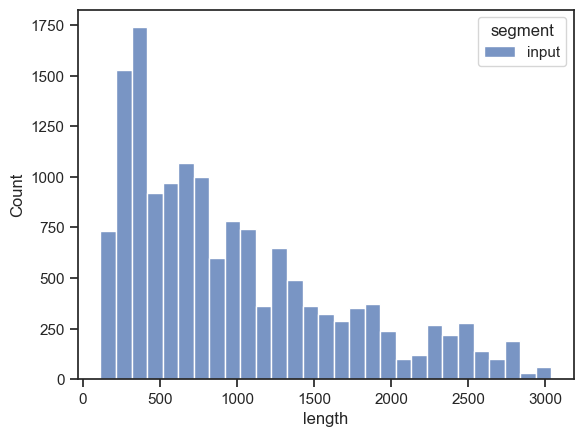

In [77]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

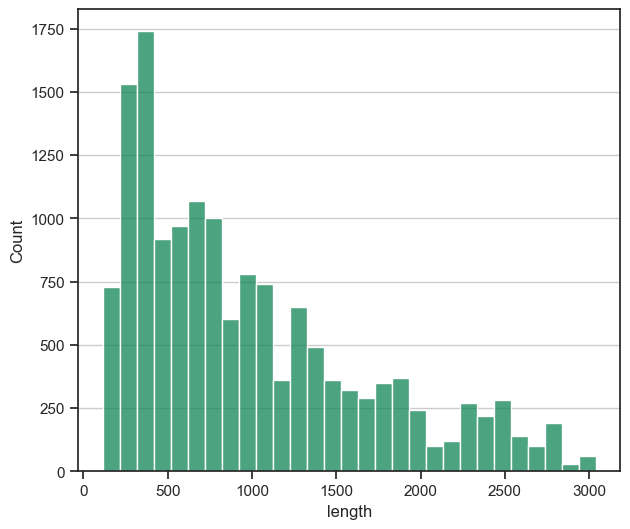

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(segments[segments.segment=='input'], x='length', color=Prism_10.mpl_colors[3], multiple='dodge', binwidth=100)

ax.yaxis.grid(True)

plt.show()

In [79]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

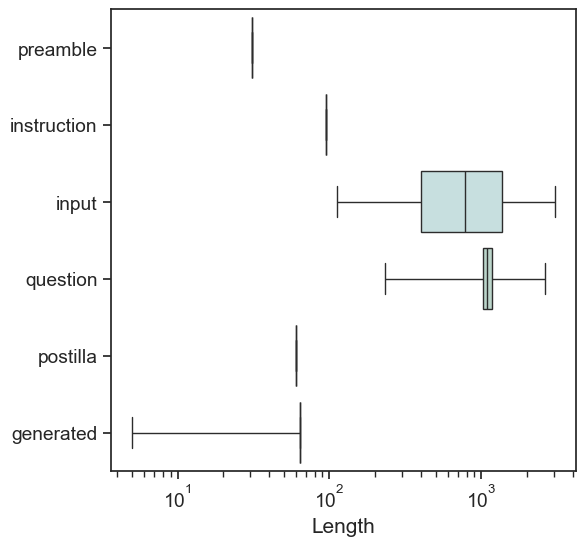

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.25)
# sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(6, 6))
ax.set_xscale("log")

sns.boxplot(
    segments, x="length", y="segment", hue="segment",
    whis=[0, 100], palette=[b[2] for b in background_regions]
)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.xaxis.grid(True)
ax.set(ylabel="", xlabel="Length")

ax.xaxis.grid(False)

plt.savefig("prompt_boxplot_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

### collect observables

In [96]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    
    # append all forward data (for run0 only)   
    if 'pre_output_proba_topn' in p:
        transpose_kl_pre = list(map(list, zip(*p['pre_output_layers_kl'])))
        for j, pp in enumerate(p['pre_output_proba_topn']):
            shapes.append((run,pid,j,'prompt',
                               len(pp['top_n_indices']),
                               p['pre_output_true_entropies'][j],
                               max(pp['top_n_probs']),
                               None,
                               None,
                               transpose_kl_pre[j],
                               None))
            # print(max(pp['top_n_probs']), max(pp['top_k_probs']))
    
    
    transpose_kl = list(map(list, zip(*p['post_output_layers_kl'])))

    # append all generation data
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs']),
                           p['transition_scores_s'][jj],
                           p['transition_scores_l'][jj],
                           transpose_kl[jj],
                           None))
    
    # check that we have all data aligned correctly among prompt and generated
    if 'pre_output_proba_topn' in p and len(p['post_output_sequences'][0]) != len(p['pre_output_proba_topn']) + len(p['post_output_true_entropies']):
        print("SOMETHING VERY BAD OCCURRED")
        break


CPU times: user 25.9 s, sys: 9.68 s, total: 35.6 s
Wall time: 39 s


In [97]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp', 'trans_s', 'trans_l', 'logitlens_kl', 'logitlens_iou'])

CPU times: user 3.79 s, sys: 732 ms, total: 4.52 s
Wall time: 4.73 s


In [98]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [99]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,15020.0,15020.000000,15020.000000,15020.000000,15020.000000,15020.000000,0.0,0.0
mean,0.0,916.181758,2256.336218,17.126565,1.563864,0.663032,NaN,NaN
std,0.0,512.878653,719.412701,27.926991,1.304587,0.282536,NaN,NaN
min,0.0,0.000000,636.000000,1.000000,0.017711,0.085449,NaN,NaN
25%,0.0,475.000000,1668.000000,1.000000,0.416530,0.421875,NaN,NaN
50%,0.0,927.500000,2089.000000,4.000000,1.352478,0.714844,NaN,NaN
75%,0.0,1363.000000,2689.250000,20.000000,2.599929,0.910156,NaN,NaN
max,0.0,1800.000000,4159.000000,214.000000,4.484863,1.000000,NaN,NaN


In [100]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,150155.000000,150155.000000,150155.000000,150155.000000,1.501550e+05,150155.000000,150155.000000,150155.000000
mean,4.500230,916.140035,2266.370391,3.613746,4.029322e-01,0.907104,-0.188027,-0.220568
std,2.872193,512.882752,719.425774,43.417435,6.743880e-01,0.165424,0.547081,0.577150
min,0.000000,0.000000,646.000000,1.000000,6.859704e-08,0.007820,-5.231133,-5.624369
25%,2.000000,475.000000,1678.000000,1.000000,2.481985e-03,0.855730,-0.076977,-0.158575
50%,5.000000,926.000000,2099.000000,1.000000,2.425199e-02,0.997524,0.000000,-0.002475
75%,7.000000,1363.000000,2700.000000,2.000000,6.763147e-01,0.999807,0.000000,-0.000192
max,9.000000,1800.000000,4169.000000,5137.000000,6.954149e+00,1.000000,0.000000,0.000000


In [101]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
print(m.shape, d.shape)
m = m[(m.tok >= m.start) & (m.tok <= m.end)] # segment indices are non-overlapping
print(m.shape) # misses last token for every run0

(25843470, 16) (4307245, 11)
(4307245, 16)
CPU times: user 3.55 s, sys: 1.41 s, total: 4.96 s
Wall time: 5.17 s


In [102]:
# check overlap between prompt and generated

In [103]:
m[(m.area=='generated') & (m.segment=='postilla')]

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length


In [104]:
m[(m.area=='prompt') & (m.segment=='generated')]

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length


In [105]:
d[['run', 'pid', 'tok']].shape, d[['run', 'pid', 'tok']].drop_duplicates().shape

((4307245, 3), (4307245, 3))

In [106]:
m[['run', 'pid', 'tok']].shape, m[['run', 'pid', 'tok']].drop_duplicates().shape

((4307245, 3), (4307245, 3))

In [107]:
m[['run', 'pid', 'tok']].sort_values(['pid', 'run', 'tok'])

,run,pid,tok
18658458,0,0,0
18658464,0,0,1
18658470,0,0,2
18658476,0,0,3
18658482,0,0,4
...,...,...,...
17917139,9,1800,1569
17917145,9,1800,1570
17917151,9,1800,1571
17917157,9,1800,1572


In [108]:
m[(m.segment=='postilla')][['run', 'pid', 'tok']]

,run,pid,tok
17776,0,129,2962
17782,0,129,2963
17788,0,129,2964
17794,0,129,2965
17800,0,129,2966
...,...,...,...
25839814,0,599,3763
25839820,0,599,3764
25839826,0,599,3765
25839832,0,599,3766


In [110]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [111]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [113]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.00028057887765422845

In [114]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0014552391338498356

In [115]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0003183784550223425

In [116]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0001347409698886814

In [117]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.09402201868304698

In [118]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.11457608640092859

In [119]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.056159592155459556

In [120]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

1.6628035399137853

In [121]:
# truth['exactly_correct'] = truth['correct']
# truth['correct'] = truth['loosely_correct']

In [122]:
answers

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,129,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with a content of 'netbal","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
1,1,129,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selected this candidate based on the information provided in the table cells. thi,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
2,2,129,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct referent entity in the list of candidates.\n\n### step 2: e","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
3,3,129,"ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever, there are a few potential issues with this answer. firstly, 'ball spor","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,## response:\nnetball [desc] ball sport [type] type of sport
4,4,129,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n\n### step 2: examining the referent entity candidate","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
...,...,...,...,...,...,...
15015,5,599,"<philippe sutherland [desc] french basketball player [type] sport cyclist]> doesn't match the entity mention 'sutherland'. there is a <sutherland [desc] suburb of sydney, australia [type] suburb> that should be chosen instead. \n\nthe final answer is: <sutherland [des","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...","<sutherland [desc] former 

In [156]:
truth

,run,pid,correct,hallucinated,loosely_correct
0,0,129,False,True,True
1,1,129,False,True,True
2,2,129,False,True,True
3,3,129,False,True,False
4,4,129,False,True,True
...,...,...,...,...,...
15015,5,599,False,True,False
15016,6,599,False,True,False
15017,7,599,False,True,False
15018,8,599,False,True,False


In [159]:
answers.head()

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,129,"netball [desc] ball sport [type] type of sport] \n\nthe final answer is: netball [desc] ball sport [type] type of sport] . i hope it is correct. in the table, row 0 has a column named col3 with a content of 'netbal","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
1,1,129,netball [desc] ball sport [type] type of sport\n\n### prompt response:\n\nthe correct referent entity for the entity mention 'netball' is 'netball [desc] ball sport [type] type of sport'. i selected this candidate based on the information provided in the table cells. thi,"[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
2,2,129,"netball [desc] ball sport [type] type of sport] ### step 1: identify the task\nthe task is an entity linking task, where we need to link the selected entity mention ""netball"" to the correct referent entity in the list of candidates.\n\n### step 2: e","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport
3,3,129,"ball [desc] ball sport [type] type of sport]. ### response:\nnetball [desc] ball sport [type] type of sport]. was chosen as the most appropriate referent entity for the given mention. \n\nhowever, there are a few potential issues with this answer. firstly, 'ball spor","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,## response:\nnetball [desc] ball sport [type] type of sport
4,4,129,">netball [desc] ball sport [type] type of sport> ### step 1: analyzing the table\nthe table contains a list of athletes and their respective sports, with a column name for 'netball' being col3.\n\n### step 2: examining the referent entity candidate","[[128000, 39314, 374, 459, 7754, 430, 16964, 264, 3465, 11, 35526, 449, 459, 1988, 430, 5825, 4726, 2317, 13, 9842, 264, 2077, 430, 36001, 45695, 279, 1715, 382, 14711, 30151, 512, 2028, 374, 459, 5502, 31799, 3465, 13, 578, 5915, 369, 420, 3465, 374, 311, 2723, 279, 4183, 5502, 6420, 304, 279, ...",<netball [desc] ball sport [type] type of sport>,netball [desc] ball sport [type] type of sport


In [176]:
# loosely is the new correct
answers_m = answers.merge(truth[['run', 'pid', 'correct', 'loosely_correct']], on=['run','pid'])
answers_m['original_answer'] = answers_m.answer

In [183]:
# replace answer with regex match, if it exists
answers_m.loc[~answers_m.regex_match.isnull(), 'answer'] = answers_m['regex_match']

In [186]:
answers_m = answers_m.drop(columns=['correct', 'loosely_correct'])

In [197]:
# revise truth
truth_m = truth.copy()
truth_m.correct = truth_m.correct | truth_m.loosely_correct

In [198]:
# dump everything for later use

if True:
    myoutdict = {'truth': truth_m, 'segments': segments, 'm': m, 'answers': answers_m, 'model_name': model_name,
                'answers_original': answers, 'truth_original': truth}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [188]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@  1 bono  staff   1.9G Apr  4 09:19 preprocessed.gemma9b.crippled.pickle
-rw-r--r--@  1 bono  staff   1.9G Apr 29 18:30 preprocessed.pickle


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Visual summary (segments and base observables)

In [137]:
%%time

with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

CPU times: user 4.62 s, sys: 1.77 s, total: 6.39 s
Wall time: 7.37 s


In [138]:
NUM_BINS = 100

98


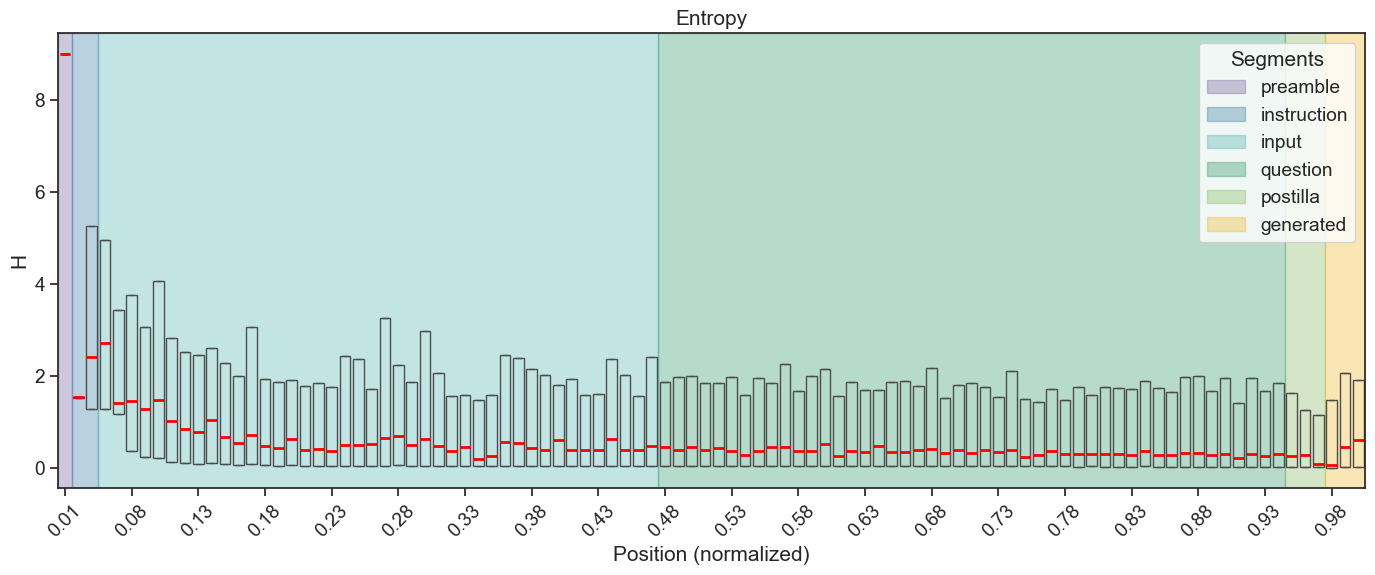

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
# ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [140]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


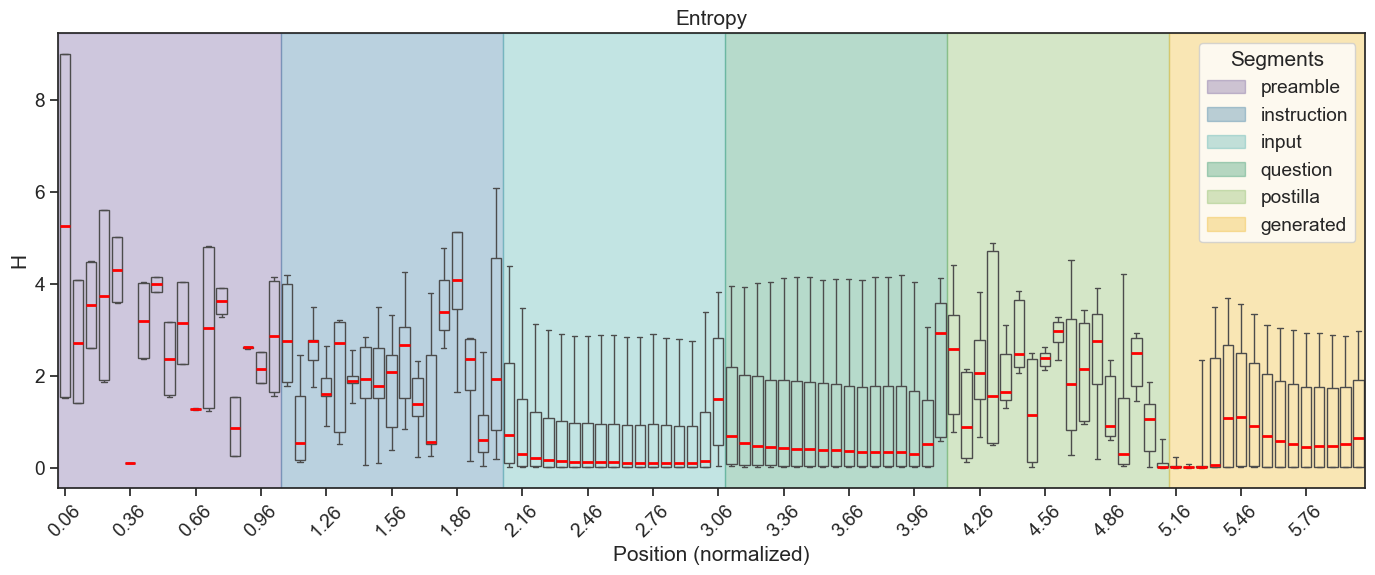

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [142]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

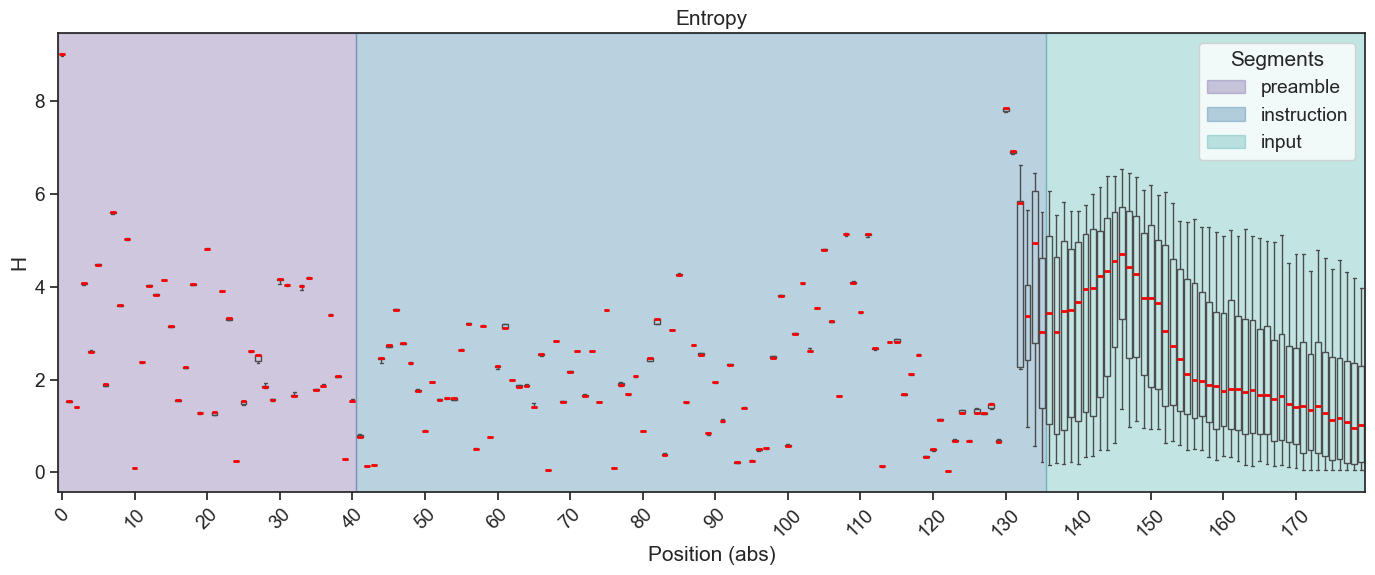

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [144]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

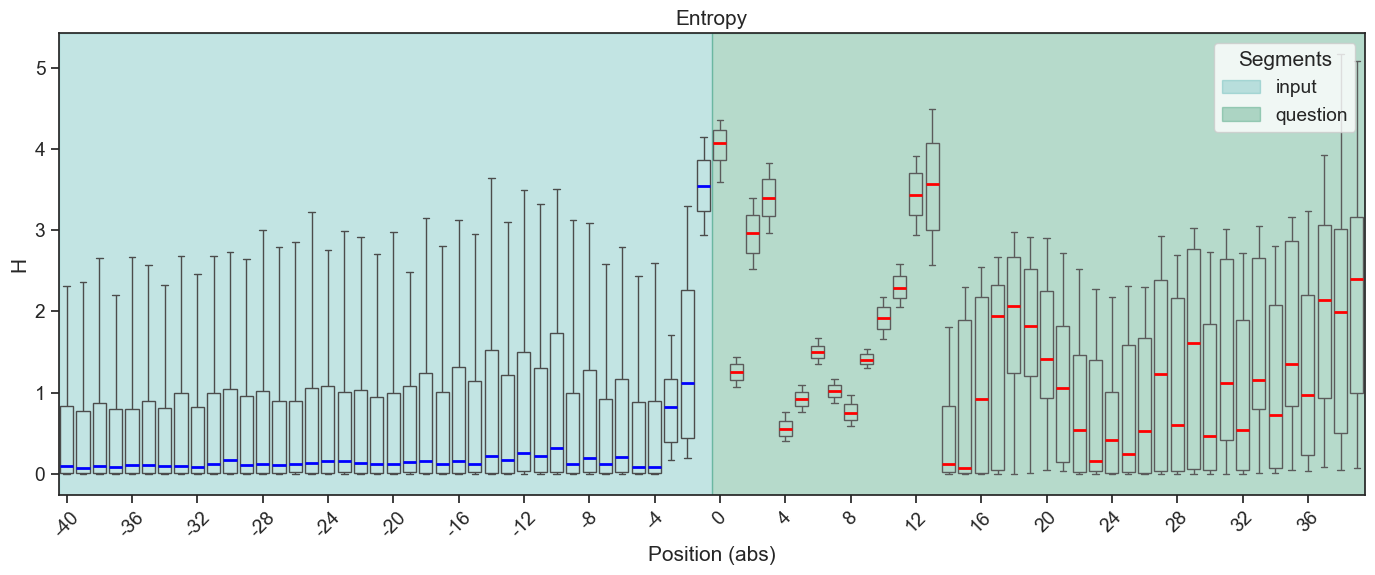

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [146]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

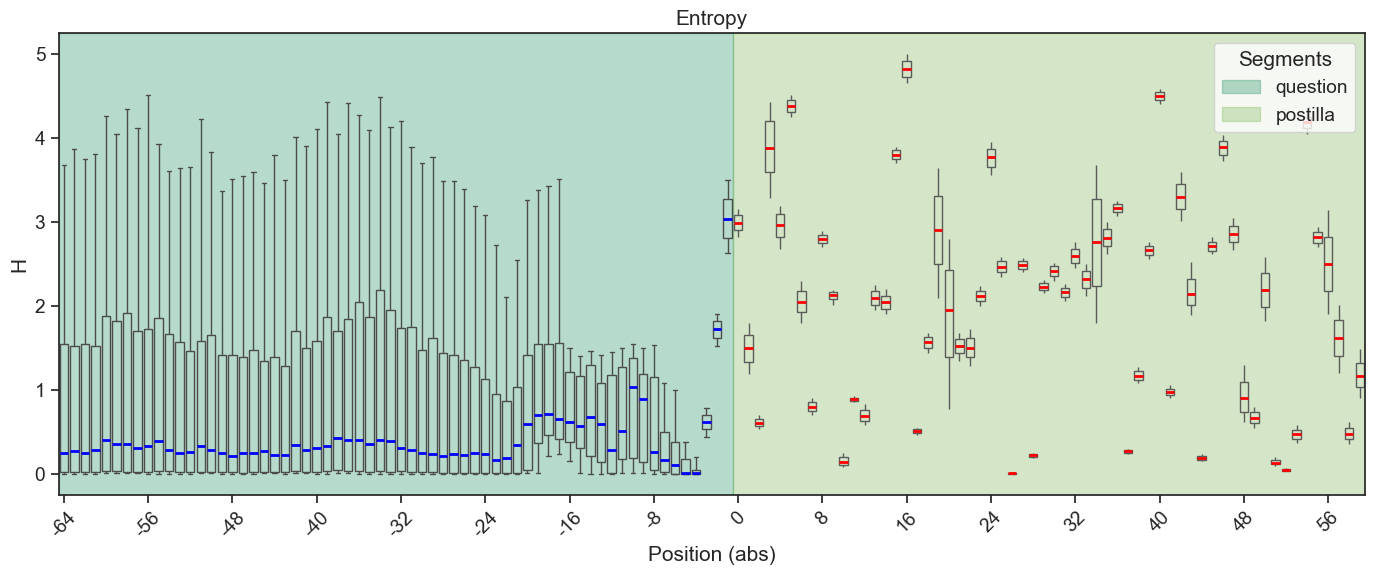

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 64
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [148]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

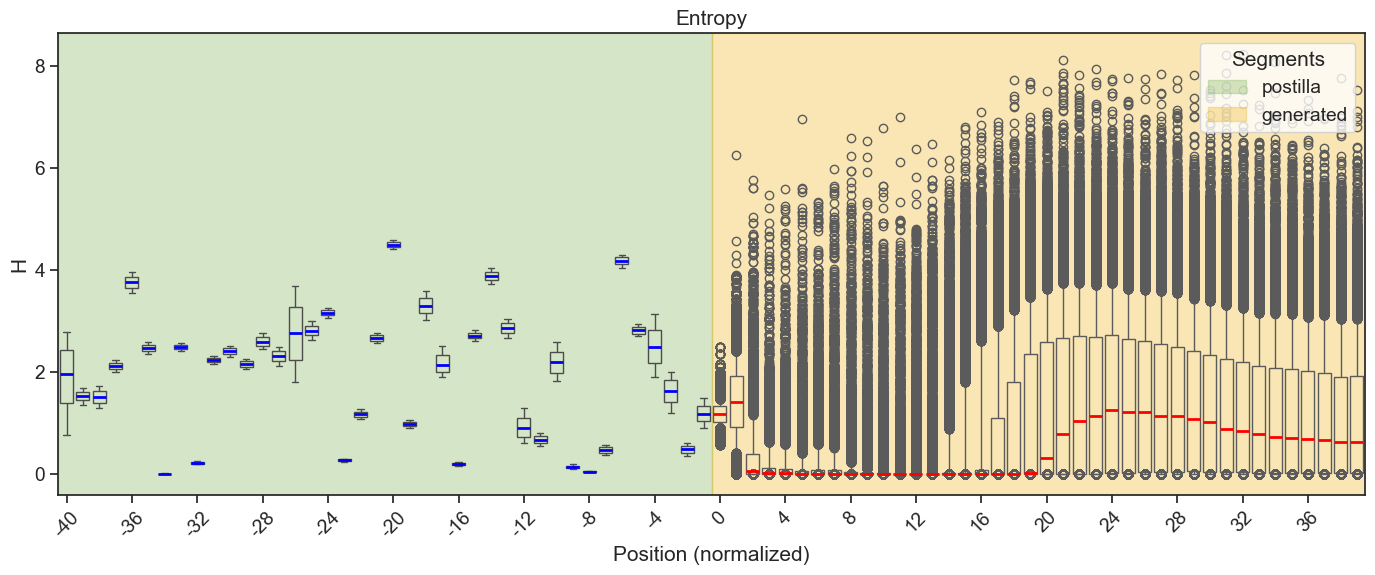

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [150]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

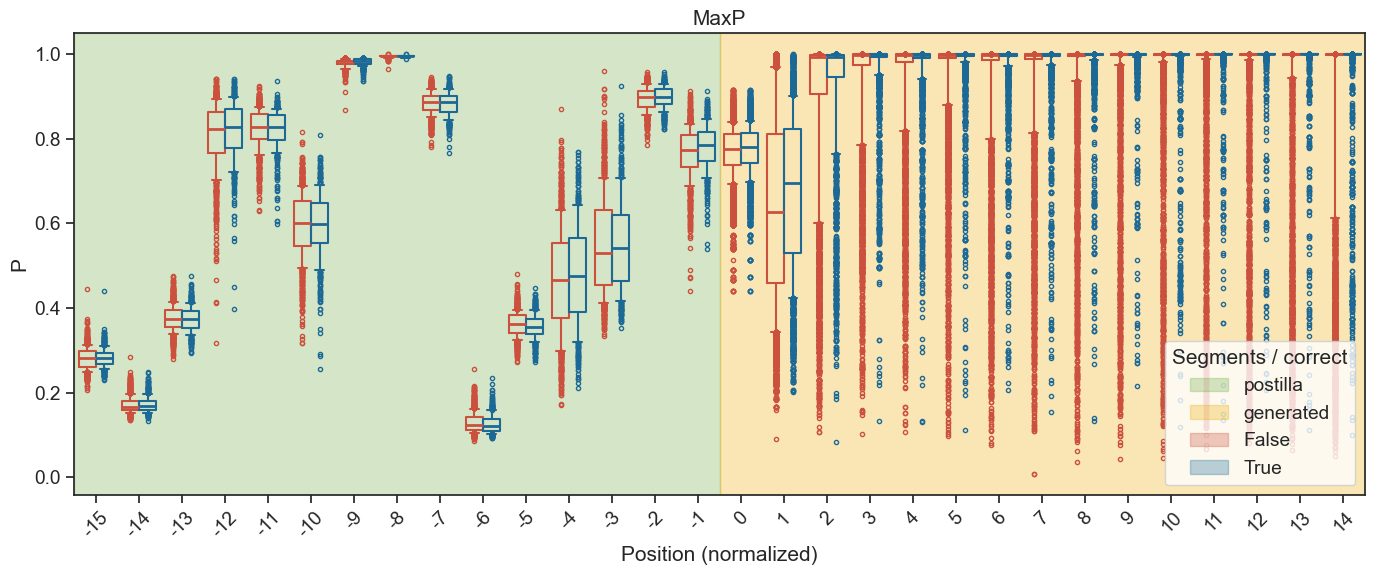

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

subpalette = [palette[7], palette[1]]
sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [152]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

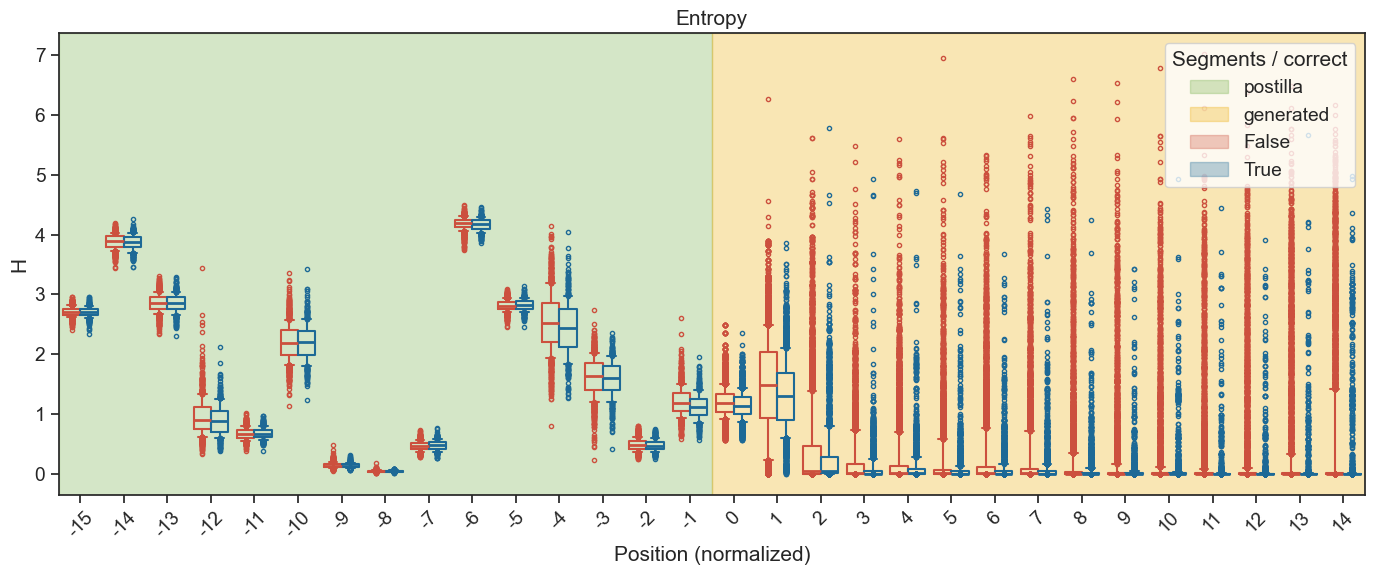

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="upper right")

plt.tight_layout()

plt.show()

98


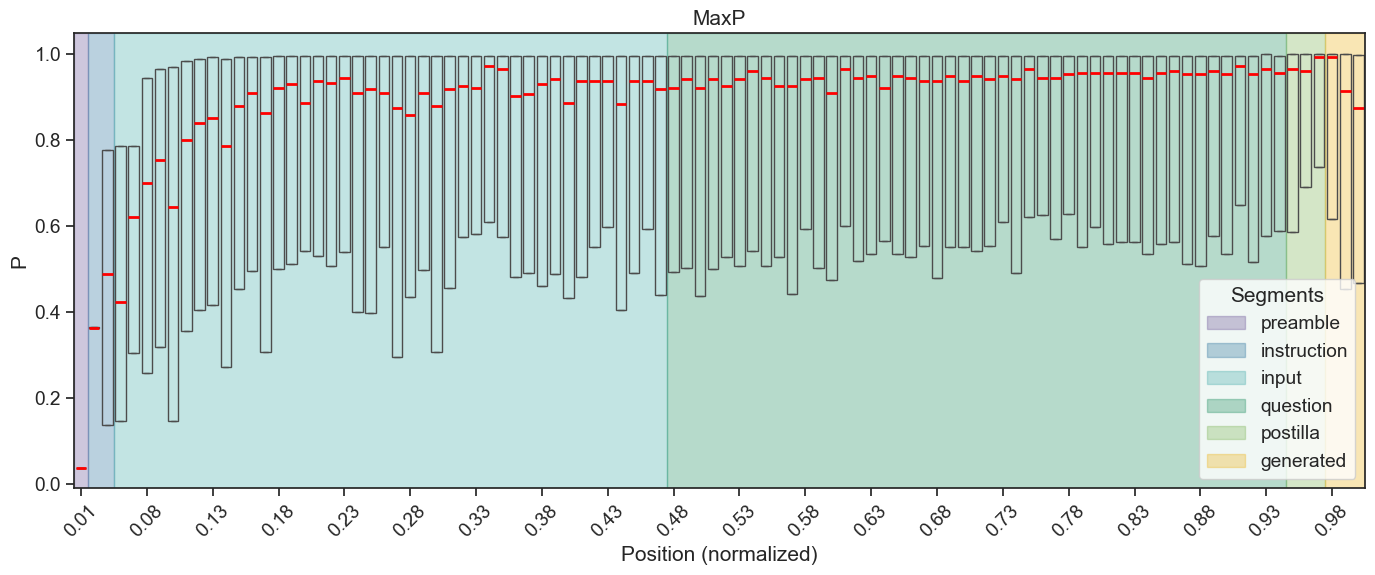

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

98


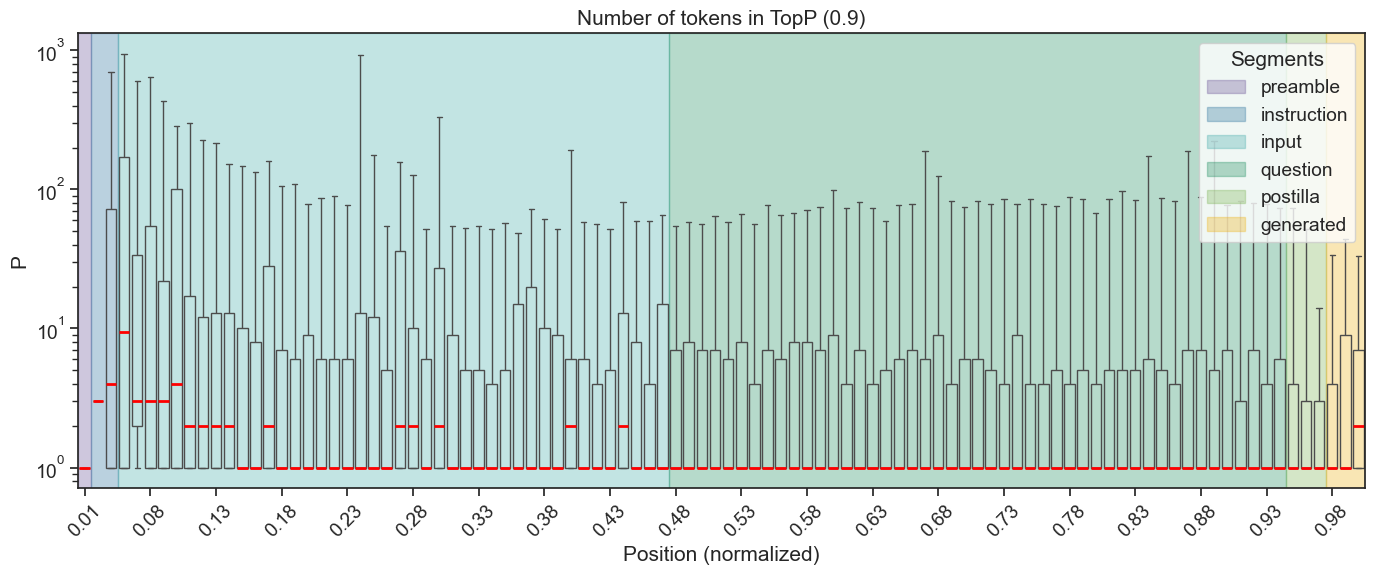

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [ ]:
mm = m.copy()

In [ ]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

In [ ]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

In [ ]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

In [ ]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

In [ ]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

In [ ]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

### search prompts for which top-p varies

In [ ]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [ ]:
mv = mm[mm.pid.isin(variators)]

In [ ]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

In [ ]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [ ]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

In [ ]:
set(v1) - set(v2)

In [ ]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

In [ ]:
# correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

In [ ]:
m_

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [ ]:
m_.groupby('shape').correct.agg(['count', 'mean'])[:20]

In [ ]:
m_.groupby('shape').correct.agg(['count', 'mean'])

In [ ]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

In [ ]:
mm[mm.segment=='generated'].true_ent.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()